In [1]:
# Install dependencies if haven't already
# !pip install mediapipe opencv-python

In [2]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt

# draw landmarks & connections to screen
mp_drawing = mp.solutions.drawing_utils
# import Pose model
mp_pose = mp.solutions.pose

In [3]:
def calc_angle(x, y, z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    radians = np.arctan2(z[1]-y[1], z[0]-y[0]) - np.arctan2(x[1]-y[1], x[0]-y[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [4]:
def recognise_curl(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global left_angle
    global right_angle
    
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # left arm
        left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y] 

        # right arm
        right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
        
        left_elbow_angle = calc_angle(left_shoulder, left_elbow, left_wrist)
        right_elbow_angle = calc_angle(right_shoulder, right_elbow, right_wrist)
        left_angle.append(int(left_elbow_angle))
        right_angle.append(int(right_elbow_angle))
        
        # down state
        if left_elbow_angle > 160 and right_elbow_angle > 160:
            if not range_flag:
                feedback = 'Did not curl completely.'
            else:
                feedback = 'Good rep!'
            state = 'Down'
            
        # not fully curled
        elif (left_elbow_angle > 50 and right_elbow_angle > 50) and state == 'Down':
            range_flag = False
            feedback = ''
            
        # up state
        elif (left_elbow_angle < 30 and right_elbow_angle < 30) and state == 'Down':
            state = 'Up'
            feedback = ''
            range_flag = True
            counter += 1
    
    except:
        left_angle.append(180)
        right_angle.append(180)

In [5]:
def recognise_squat(detection):
    
    global counter
    global state
    global feedback
    global left_angle
    global right_angle
       
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # GET COORDINATES
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y]
        
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

        left = calc_angle(left_hip, left_knee, left_heel)
        right = calc_angle(right_hip, right_knee, right_heel)        
        left_angle.append(int(left))
        right_angle.append(int(right))
        
        #POSE CHECKING 1: Knees bending inwards    
        shoulder_dist = left_shoulder[0] - right_shoulder[0]
        knee_dist = left_knee[0] - right_knee[0]

        if shoulder_dist - knee_dist > 0.04:
            feedback = 'Open up your knees further apart to shoulder width!'
        else:
            feedback = ''

        # standing up
        if left > 170 and right > 170:
            state = "Up"
            
        if left < 165 and right < 165:
            feedback = 'Almost there... lower until height of hips!'
            
        if left < 140 and right < 140 and state == "Up":
            state = "Down"
            counter += 1
            
        if state == "Down":
            feedback = 'Good rep!'
    
    except:
        left_angle.append(180)
        right_angle.append(180)

In [6]:
def plot_viz(user_choice):
    
    # Set figure size
    plt.rcParams["figure.figsize"] = (20,5)
    
    # Squat viz
    if user_choice == 1:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Knee Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Knee Angle')
        ax.axhline(y=140, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'You managed {counter} repetitions!')
        
    # Curl viz
    elif user_choice == 2:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Arm Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Arm Angle')
        ax.axhline(y=30, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'You managed {counter} repetitions!')
        
    # Situp viz
#     else:
        
    

Which exercise would you like to do?
1. Squat 
2. Curl 
3. Sit-up
 2


You managed 7 repetitions!


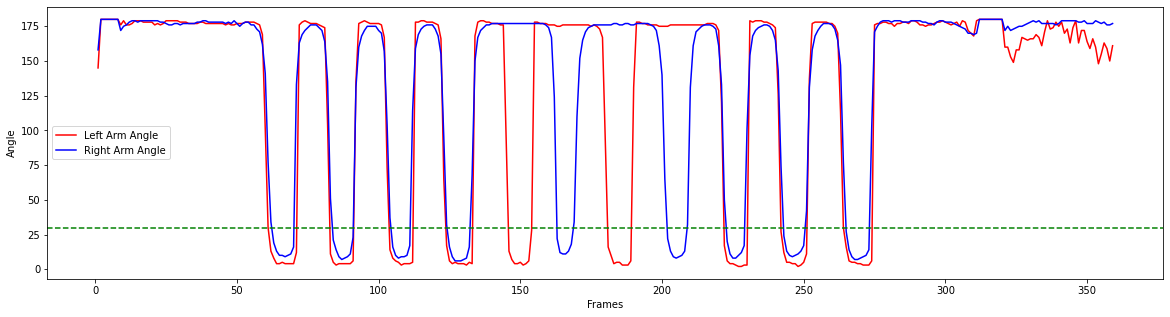

In [7]:
# initialise variables
counter = 0
state = 'Down'
range_flag = True
feedback = ''
frame_count = 0
# Plotting variables
frames = []
left_angle = []
right_angle = []

# Prompt user input for exercise selection
while True:
    try:
        user_choice = int(input('Which exercise would you like to do?\n1. Squat \n2. Curl \n3. Sit-up\n'))
        if user_choice in [1, 2, 3]:
            break
        else:
            print("Please enter either integer 1, 2 or 3")
    except:
        print("Please enter either integer 1, 2 or 3")

# Open webcam
feed = cv2.VideoCapture(0)

# Get user's maximum resolution
WIDTH = 10000
HEIGHT = 10000
feed.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
feed.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
width = int(feed.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(feed.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Mediapipe Pose model instance
with mp_pose.Pose(min_detection_confidence=50, min_tracking_confidence=50) as pose:
    while feed.isOpened():
        ret, frame = feed.read()
        frame_count += 1
        frames.append(frame_count)
        # Mirror frame
        frame = cv2.flip(frame, 1)
        # Recolor image from BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Pose detection
        detection = pose.process(image)
        # Recolor image from RGB back to BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = True

        # Render detections
        mp_drawing.draw_landmarks(image, detection.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        # Recognise particular exercise based on user input
        if user_choice == 1:
            recognise_squat(detection)
        elif user_choice == 2:
            recognise_curl(detection)
#         else:
#             recognise_situp(detection)
        

        # Status box setup
        cv2.rectangle(image, (0,0), (width, int(height*0.1)), (245,117,16), -1)
        cv2.putText(image, "REPS:", (int(width*0.01), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) # font, size, color, line width, line type
        
        cv2.putText(image, "STATE:", (int(width*0.1), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, "FEEDBACK:", (int(width*0.2), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, str(counter), (int(width*0.01), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, state, (int(width*0.1), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, feedback, (int(width*0.2), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        window_name = 'Exercise Counter'
        
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.imshow(window_name, image)
        
        # quit webcam
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()
cv2.waitKey(1)
feed.release()

plot_viz(user_choice)